In [1]:
%pylab inline
from pylab import *
import cv2
from skimage.transform import resize
import math

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_im(filepath):
    if filepath[len(filepath)-3:] == 'tif':
        return imread(filepath)/65536.0
    return imread(filepath)/255.0

im = read_im('../data/cathedral.jpg')

print("Size of the image is %d x %d" % (im.shape[0], im.shape[1]))
print("Size of the individual plates is %d x %d" % (im.shape[0] // 3, im.shape[1]))


Size of the image is 1024 x 390
Size of the individual plates is 341 x 390


In [3]:
def crop(image, divisor):
    # Returns image/divisor centered at image's center
    # Crops y pixels off the top and bottom and x pixels off the sides.
    # Subtracts (dimension/divisor) from each dimension.
    h, w = image.shape[:2]
    crop_y = int((h / divisor) / 2)
    crop_x = int((w / divisor) / 2)
    return image[crop_y:h-crop_y, crop_x:w-crop_x]

In [80]:
def crop_pixels(image, px_y, px_x):
    # Returns an image with pixels cropped off all sides
    return image[px_y:image.shape[0] - px_y, px_x:image.shape[1] - px_x]

In [4]:
def make_dims_even(image):
    h = image.shape[0]
    w = image.shape[1]
    # Reduce the dimension if odd.
    h = h - (h % 2)
    w = w - (w % 2)
    return image[:h, :w]

In [5]:
def separate_images(image):
    """
    Helper Function.
    Returns a tuple of (blue_image, green_image, red_image) separated from one monolithic image.
    """
    # Extract the 3 images
    height = image.shape[0] // 3
    width  = image.shape[1]
    blu_im = image[          :height, :width]
    gre_im = image[  height:2*height, :width]
    red_im = image[2*height:3*height, :width]
    
    return (blu_im, gre_im, red_im)

In [6]:
def ncc(u, v):
    """
    Normalized Cross Correlation
    """
    u_norm = (u / np.linalg.norm(u)).ravel()
    v_norm = (v / np.linalg.norm(v)).ravel()
    return np.dot(u_norm, v_norm)


In [7]:
def translate(im, translation):
    """
    Helper function that translates an image.
    """
    height, width = im.shape[:2]
    mat = translation_matrix = np.array([
        [1, 0, translation[1]],
        [0, 1, translation[0]]
    ], dtype=np.float32)
    return cv2.warpAffine(im, mat, (width, height))

In [8]:
def colorize(blue_im, green_im, red_im, green_alignment, red_alignment):   
    h = blue_im.shape[0]
    w = blue_im.shape[1]

    composite = np.zeros((h, w, 3))
    
    green_translated = translate(green_im, green_alignment)
    red_translated = translate(red_im, red_alignment)

    for y in range(0, h):
        for x in range(0, w):
            composite[y][x][0] = red_translated[y][x]
            composite[y][x][1] = green_translated[y][x]
            composite[y][x][2] = blue_im[y][x]
    
    return composite

In [107]:
def create_pyramid(image):
    max_depth = 1
    h, w = image.shape[:2]
    # Figure out how many levels could cleanly fit into image. Either log_2(height) or log_2(width)
    levels_y = math.floor(int(math.log(h, 2)))
    levels_x = math.floor(int(math.log(w, 2)))
    num_levels = min(levels_y, levels_x, max_depth)
    pyramid = []
    # Add the levels to the pyramid, from lowest res -> highest res
    for i in reversed(range(0,num_levels)):
        scale = 2**i
        level_image = resize(image, (image.shape[0]//scale, image.shape[1]//scale))
        # To make things nice, ensure the dimensions are even by cutting a pixel off the edge.
        if level_image.shape[0] % 2 or level_image.shape[1] % 2:
            level_image = make_dims_even(level_image)
        pyramid.append(level_image)
        
        
    return pyramid

In [128]:
def align(u, v):
    """
        Aligns v to u and returns the best translation vector.
    """
    # Get dimensions of u.
    hu, wu = u.shape[:2]
    # Search within +/- 15px. 
    scan_y = 15
    scan_x = 15
    # If the matrix is smaller than that, search within a range of +/- 0.5dimension
    if v.shape[0]/2 < scan_y:
        scan_y = v.shape[0]//2
    if v.shape[1]/2 < scan_x:
        scan_x = v.shape[1]//2
    
    max_ncc = -1
    best_dy = None
    best_dx = None

    # Crop v.
    v_crop = v[scan_y:-scan_y, scan_x:-scan_x]
    # Get dimensions of v_crop
    hv, wv = v_crop.shape[:2]
    # Scan through the search area range and pick the translation with the best Normalized Cross Correlation.
    for dy in range(-scan_y, scan_y+1):        
        for dx in range(-scan_x, scan_x+1):
            # Crop u to part overlapping with v_crop.
            min_y = scan_y + dy      # min_y = 0 when dy = -scan_y
            max_y = hu - scan_y + dy # max_y = hu when dy = +scan_y
            min_x = scan_x + dx      # min_x = 0 when dx = -scan_x
            max_x = wu - scan_x + dx # max_x = wu when dx = +scan_x 
            u_crop = u[min_y:max_y, min_x:max_x]
            """ ignore the dumb cases for now
            d_min_y = 0
            d_max_y = 0
            d_max_x = 0
            d_min_x = 0
            
            if min_y < 0:
                d_min_y = -min_y
                min_y = 0
            if max_y > hu:
                d_max_y = max_y - hu
                max_y = hu
            if min_x < 0:
                d_min_x = -min_x
                min_x = 0
            if max_x > wu:
                d_max_x = max_x - wu
                max_x = wu
            # If any of these conditions are triggered, we need to recrop v so the dimensions match.
            if d_min_y > 0 or d_max_y > 0 or d_max_x > 0 or d_min_x > 0:
                v_translated = v_translated[d_min_y:-d_max_y, d_min_x:-d_max_x]
    

            # Debug
            if u_cropped.shape != v_translated.shape: # Bug: at lowest level u_cropped.shape = (2,2), v_translated.shape = (2,3)
                print(f"shape bad!: {u_cropped.shape}, {v_translated.shape}, dy, dx = {dy}, {dx}")
                print(f"u: dims = ({hu}, {wu}), center = {center_y}, {center_x}")
                print(f"v: half dims = ({half_hv}, {half_wv})")
                print(f"crop bounds: y:({min_y}, {max_y}), x:({min_x}, {max_x})")
            """
            # Calculate the Normalized Cross Correlation.
            score = ncc(u_crop, v_crop)
            #print(f"ncc score = {score}, at {dy, dx}")
            # Replace previous maximum if greater.
            if score > max_ncc:
                #print(f"Max found {score}, at {dy, dx}")
                max_ncc = score
                best_dy = dy
                best_dx = dx
    
    new_best_estimate = (best_dy, best_dx)
    return new_best_estimate

In [126]:
def pyramid_align(pyramid_a, pyramid_b):
    """
    Aligns image b to image a (represented as image pyramids)
    Calls align() on the pyramid from the bottom level to the top original.
    Returns a translation that is the best alignment for the top images of each pyramid.
    """
    estimate = (0, 0)
    # Get the top level image from a (blue reference image)
    # Crop by 10%
    image_a = crop(pyramid_a[len(pyramid_a)-1], 10)
    for i in range(len(pyramid_a)):
        print(f"\npyramid loop level {i}")
        # Scale estimate translations by 2 to account for scaling.
        estimate = (estimate[0]*2, estimate[1]*2)
        
        # Get the current level image.
        image_b = pyramid_b[i]
        #Update image b to the current esimated alignment.
        image_b = translate(image_b, estimate)
        # Crop by 10%
        image_b = crop(image_b, 10)

        # Get the new estimate.
        updated_estimate = align(image_a, image_b)
        print(f"current estimate = {estimate}, updated estimate = {updated_estimate}")
        
        # Update the estimate by adding the translations.
        estimate = ((estimate[0] + updated_estimate[0]), (estimate[1] + updated_estimate[1]))
        print(f"updated estimate + old estimate = {estimate}")

        
    return estimate

In [25]:
def align_and_colorize(image_filepath):
    # Read in the image.
    full_image = read_im(image_filepath)

    # Get 3 photos.
    blue_im, green_im, red_im = separate_images(full_image)
    
    # Create image pyramid for each sub-image.
    blue_pyramid = create_pyramid(blue_im)
    green_pyramid = create_pyramid(green_im)
    red_pyramid = create_pyramid(red_im)

    # Align green to blue
    print(f"\nAligning Green pyramid------------------------------")
    green_alignment = pyramid_align(blue_pyramid, green_pyramid)
    
    # Align red to blue
    print(f"\nAligning Red pyramid------------------------------")
    red_alignment = pyramid_align(blue_pyramid, red_pyramid)

    # Stack the images
    composite = colorize(blue_im, green_im, red_im, green_alignment, red_alignment)
    
    # Crop by 10% to get the final result.
    cropped_composite = crop(composite, 10)
        
    return cropped_composite, green_alignment, red_alignment


In [13]:
def test_align_and_colorize(filepath):
    (image, green_alignment, red_alignment) = align_and_colorize(filepath)
    imshow(image)
    print(f"Green alignment = {green_alignment}, Red alignment = {red_alignment}.")
    return (image, green_alignment, red_alignment)


Aligning Green pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (5, 2)
updated estimate + old estimate = (5, 2)

Aligning Red pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (12, 3)
updated estimate + old estimate = (12, 3)
Green alignment = (5, 2), Red alignment = (12, 3).


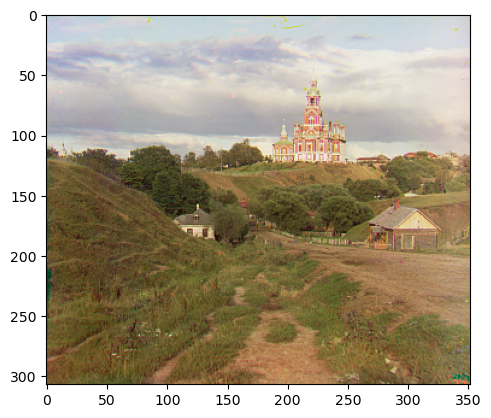

In [129]:
cathedral = test_align_and_colorize('../data/cathedral.jpg')


Aligning Green pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (-3, 2)
updated estimate + old estimate = (-3, 2)

Aligning Red pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (3, 2)
updated estimate + old estimate = (3, 2)
Green alignment = (-3, 2), Red alignment = (3, 2).


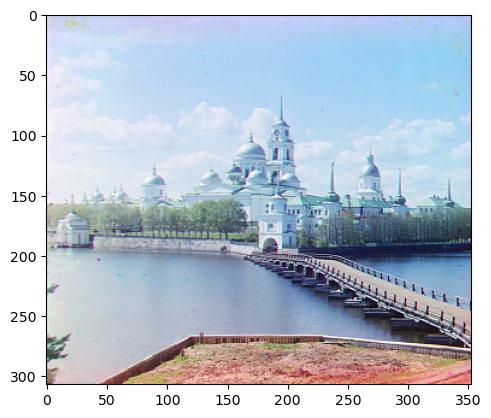

In [130]:
monastery = test_align_and_colorize('../data/monastery.jpg')


Aligning Green pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (3, 3)
updated estimate + old estimate = (3, 3)

Aligning Red pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (6, 3)
updated estimate + old estimate = (6, 3)
Green alignment = (3, 3), Red alignment = (6, 3).


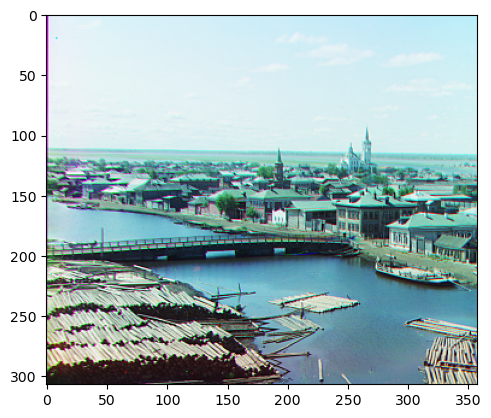

In [131]:
tobolsk = test_align_and_colorize('../data/tobolsk.jpg')


Aligning Green pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (15, 9)
updated estimate + old estimate = (15, 9)

Aligning Red pyramid------------------------------

pyramid loop level 0
current estimate = (0, 0), updated estimate = (15, 15)
updated estimate + old estimate = (15, 15)
Green alignment = (15, 9), Red alignment = (15, 15).


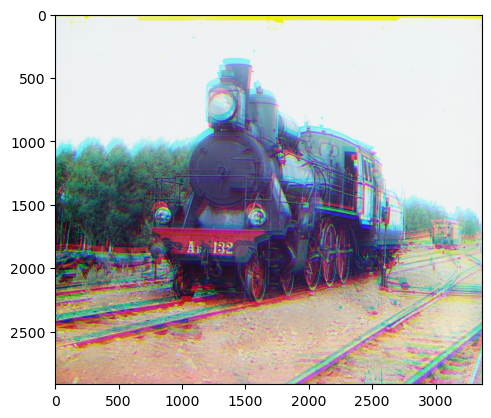

In [132]:
image2, ga2, ra2 = test_align_and_colorize('../data/train.tif')